In [2]:
import sys
import os
import time
import logging
import datetime
from datetime import datetime, timedelta
import yaml
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import requests
import pandas_gbq
from dreams_core.googlecloud import GoogleCloud as dgc
from dreams_core import core as dc
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# load dotenv
load_dotenv()


# import local files if necessary
sys.path.append('..//src')
from utils import load_config, cw_filter_df
import training_data as td
importlib.reload(td)
import feature_engineering as fe
importlib.reload(fe)
import coin_wallet_metrics as cwm
importlib.reload(cwm)


# configure logger
logger = dc.setup_logger()
logger.setLevel(logging.INFO)

# Custom format function for displaying numbers
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

#### Load the datasets

In [3]:
importlib.reload(td)
config = load_config()


# retrieve prices data
prices_df = td.retrieve_prices_data()

# fill gaps in prices data
prices_df,_ = td.fill_prices_gaps(prices_df,config['data_cleaning']['max_gap_days'])
logger.info(f"Prices data shape: {prices_df.shape}")

# retrieve transfers data
transfers_df = td.retrieve_transfers_data(
    config['training_data']['training_period_start'],
    config['training_data']['modeling_period_start'],
    config['training_data']['modeling_period_end']
    )
logger.info(f"Transfers data shape: {transfers_df.shape}")

# compile profits_df
profits_df = td.prepare_profits_data(transfers_df, prices_df)
profits_df = td.calculate_wallet_profitability(profits_df)
profits_df,_ = td.clean_profits_df(profits_df, config['data_cleaning'])
logger.info(f"Profits data shape: {profits_df.shape}")


# identify sharks
shark_coins_df = td.classify_shark_coins(profits_df, config['training_data'])
shark_wallets_df = td.classify_shark_wallets(shark_coins_df,config['training_data'])


# assess shark performance
shark_agg_performance_df,shark_wallets_performance_df = td.calculate_shark_performance(transfers_df, prices_df, shark_wallets_df, config)
metrics = ['count_wallets', 'return_aggregate', 'nonzero_count_wallets', 'nonzero_median_return', 'midrange_count_wallets', 'midrange_median_return', 'midrange_return_aggregate']
shark_agg_performance_df[shark_agg_performance_df['metric'].isin(metrics)]

[11/Sep/2024 14:52:19] INFO [dreams_core.core.retrieve_prices_data:42] retrieved prices data with shape (120763, 3)
[11/Sep/2024 14:52:19] INFO [dreams_core.core.fill_prices_gaps:126] 382 coins had no gaps, 19 coins had gaps filled, and 38 coins were dropped due to large gaps.
[11/Sep/2024 14:52:19] INFO [dreams_core.core.<module>:10] Prices data shape: (110929, 3)
[11/Sep/2024 14:53:02] INFO [dreams_core.core.retrieve_transfers_data:414] retrieved transfers_df with shape (25520299, 5) after 42.2 seconds.
[11/Sep/2024 14:53:02] INFO [dreams_core.core.<module>:18] Transfers data shape: (25520299, 5)
[11/Sep/2024 14:53:02] INFO [dreams_core.core.prepare_profits_data:455] Preparing profits_df data...
[11/Sep/2024 14:53:59] INFO [dreams_core.core.calculate_wallet_profitability:635] Generated profits df after 23.78 seconds


In [ ]:
profits_df_full = profits_df
training_profits_df = profits_df[profits_df['date']<=config['training_data']['training_period_end']]
training_end_profits_df = profits_df[profits_df['date']==config['training_data']['training_period_end']]

print(profits_df_full.shape)
print(training_profits_df.shape)
print(training_end_profits_df.shape)


cohort_wallets = shark_coins_df['wallet_address'].unique()
cohort_coins = shark_coins_df['coin_id'].unique()
print(len(cohort_wallets))
print(len(cohort_coins))

(20802642, 13)
(11230792, 13)
(3775241, 13)
123648
139


In [ ]:
importlib.reload(cwm)
importlib.reload(fe)

metadata_df,cohort_profits_df = cwm.prepare_datasets(profits_df,cohort_wallets,cohort_coins)



[11/Sep/2024 14:01:36] INFO [dreams_core.core.prepare_datasets:93] Retrieving datasets required for wallet balance metrics...
[11/Sep/2024 14:01:42] INFO [dreams_core.core.prepare_datasets:137] Generated cohort profits_df after 5.71 seconds.


,coin_id,wallet_address,date,balance,net_transfers,buy_sequence,sell_sequence
58,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-17,858.493983617,858.493983617,1,NaN
59,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-18,1380.57515462,522.081170999,2,NaN
60,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-24,69.02875773,-1311.54639689,NaN,1
61,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-04-30,69.02875773,0,NaN,NaN
62,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-05-01,69.02875773,0,NaN,NaN


In [1]:
cohort_profits_df.head()

NameError: name 'cohort_profits_df' is not defined

In [61]:
def generate_buysell_features_df(cohort_profits_df):
    """
    Generates features_df by looping through each coin_id and applying the feature calculation function.

    Params:
    - cohort_profits_df (pd.DataFrame): DataFrame containing profits data for a set of wallet-coin_id pairs

    Returns:
    - features_df (pd.DataFrame): DataFrame containing features for all coin_ids.
    """
    # Initialize an empty list to store DataFrames for each coin
    coin_features_list = []

    # Loop through all unique coin_ids
    for c in metadata_df['coin_id'].unique():
        # Filter cohort_profits_df for the current coin_id and create a copy
        coin_cohort_profits_df = cohort_profits_df[cohort_profits_df['coin_id'] == c].copy()

        # Call the feature calculation function
        coin_features_df = calculate_buyer_seller_counts_func(coin_cohort_profits_df)

        # Add coin_id back to the DataFrame to retain coin information
        coin_features_df['coin_id'] = c

        # Append the result to the list
        coin_features_list.append(coin_features_df)

    # Concatenate all features DataFrames into a single DataFrame
    features_df = pd.concat(coin_features_list, ignore_index=True)

    return features_df


,date,buyers_new,buyers_repeat,total_buyers,new_vs_repeat_buy_ratio,sellers_new,sellers_repeat,total_sellers,new_vs_repeat_sell_ratio,total_bought,total_sold,total_net_transfers,buyers_to_sellers_ratio,new_buyers_to_new_sellers_ratio,sentiment_score,coin_id
0,2024-01-01,167,0,167,0,0,0,0,0,836480135.129,0,836480135.129,0,0,1,3f17e65a-82ea-4699-9f12-65a5e1e52ae3
1,2024-01-02,1,10,11,0.1,6,0,6,0,5715712.49105,8222288,-2506575.50895,1.83333333333,0.166666666667,1,3f17e65a-82ea-4699-9f12-65a5e1e52ae3
2,2024-01-03,1,7,8,0.142857142857,1,1,2,1,4272512.75747,2001608.34465,2270904.41282,4,1,1,3f17e65a-82ea-4699-9f12-65a5e1e52ae3
3,2024-01-04,0,3,3,0,1,0,1,0,2369235.6413,2957713.85588,-588478.21458,3,0,1,3f17e65a-82ea-4699-9f12-65a5e1e52ae3
4,2024-01-05,0,3,3,0,4,0,4,0,2107993.72717,3050752.36208,-942758.634911,0.75,0,1,3f17e65a-82ea-4699-9f12-65a5e1e52ae3


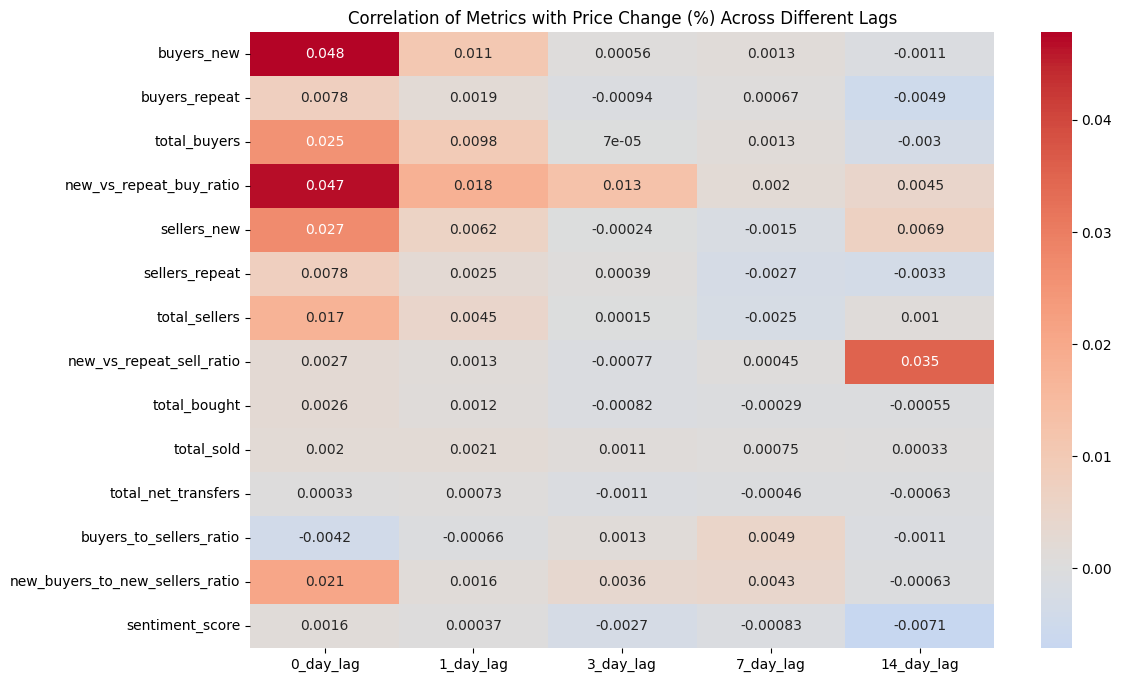

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Merge DataFrames on 'coin_id' and 'date'
merged_df = pd.merge(features_df, prices_df, on=['coin_id', 'date'])

# Step 2: Calculate price percentage change
merged_df['price_change_pct'] = merged_df.groupby('coin_id')['price'].pct_change()

# Step 3: Select numeric columns (exclude price and price_change_pct)
metrics_cols = merged_df.select_dtypes(include=[float, int]).columns
metrics_cols = metrics_cols.drop(['price', 'price_change_pct'])

# Initialize a DataFrame to store correlations across different lags
lagged_correlations = pd.DataFrame(index=metrics_cols)

# Step 4: Calculate correlation for each lag
for lag in [0, 1, 3, 7, 14]:
    # Shift the metrics by the specified lag
    lagged_df = merged_df.copy()
    lagged_df[metrics_cols] = lagged_df.groupby('coin_id')[metrics_cols].shift(lag)
    
    # Calculate correlation of metrics with price_change_pct
    correlation = lagged_df[metrics_cols].corrwith(lagged_df['price_change_pct'])
    
    # Store in the DataFrame
    lagged_correlations[f'{lag}_day_lag'] = correlation

# Step 5: Plot heatmap for correlations across different lags
plt.figure(figsize=(12, 8))
sns.heatmap(lagged_correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Metrics with Price Change (%) Across Different Lags')
plt.show()


In [54]:
importlib.reload(cwm)

buysell_df = cwm.calculate_buyer_seller_counts(coin_cohort_profits_df)
buysell_df.head()

/Users/jeremymeadow/DreamsData/GitHub/data-science/notebooks/..//src/coin_wallet_metrics.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ,wt.wallet_address


,date,buyers_new,buyers_repeat,total_buyers,new_vs_repeat_buy_ratio,sellers_new,sellers_repeat,total_sellers,new_vs_repeat_sell_ratio,total_bought,total_sold,total_net_transfers,buyers_to_sellers_ratio,new_buyers_to_new_sellers_ratio,sentiment_score
0,2024-03-13,227,20,247,11.35,0,0,0,0,1289758.53651,0,1289758.53651,0,0,1
1,2024-03-14,58,11,69,5.27272727273,40,0,40,0,139494.132729,126818.533696,12675.5990335,1.725,1.45,1
2,2024-03-15,19,18,37,1.05555555556,19,6,25,3.16666666667,66736.9112817,63560.1092951,3176.80198666,1.48,1,1
3,2024-03-16,20,17,37,1.17647058824,12,9,21,1.33333333333,66147.7670843,54511.8430239,11635.9240604,1.7619047619,1.66666666667,1
4,2024-03-17,24,17,41,1.41176470588,16,8,24,2,48536.1127564,38110.7740611,10425.3386954,1.70833333333,1.5,1


In [55]:
prices_df

,date,coin_id,price
0,2024-03-11,004cb3d0-0803-4208-a9e1-c3457567ea3f,0.0018422483042
1,2024-03-12,004cb3d0-0803-4208-a9e1-c3457567ea3f,0.0018422483042
2,2024-03-13,004cb3d0-0803-4208-a9e1-c3457567ea3f,0.00185346149497
3,2024-03-14,004cb3d0-0803-4208-a9e1-c3457567ea3f,0.00371872447609
4,2024-03-15,004cb3d0-0803-4208-a9e1-c3457567ea3f,0.00329463860539
...,...,...,...
110924,2024-09-01,fe5bc8b4-817b-4a05-9d15-5d770cc75ad2,3.86452699976e-09
110925,2024-09-02,fe5bc8b4-817b-4a05-9d15-5d770cc75ad2,3.97322070995e-09
110926,2024-09-03,fe5bc8b4-817b-4a05-9d15-5d770cc75ad2,5.00002620942e-09
110927,2024-09-04,fe5bc8b4-817b-4a05-9d15-5d770cc75ad2,4.43496010107e-09


In [53]:
buysell_df

,date,buyers_new,buyers_repeat,total_buyers,new_vs_repeat_buy_ratio,sellers_new,sellers_repeat,total_sellers,new_vs_repeat_sell_ratio,total_bought,total_sold,total_net_transfers,buyers_to_sellers_ratio,new_buyers_to_new_sellers_ratio,sentiment_score
0,2024-03-13,227,20,247,11.35,0,0,0,0,1289758.53651,0,1289758.53651,0,0,1
1,2024-03-14,58,11,69,5.27272727273,40,0,40,0,139494.132729,126818.533696,12675.5990335,1.725,1.45,1
2,2024-03-15,19,18,37,1.05555555556,19,6,25,3.16666666667,66736.9112817,63560.1092951,3176.80198666,1.48,1,1
3,2024-03-16,20,17,37,1.17647058824,12,9,21,1.33333333333,66147.7670843,54511.8430239,11635.9240604,1.7619047619,1.66666666667,1
4,2024-03-17,24,17,41,1.41176470588,16,8,24,2,48536.1127564,38110.7740611,10425.3386954,1.70833333333,1.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2024-05-27,3,23,26,0.130434782609,2,11,13,0.181818181818,14209.7544157,18483.970496,-4274.21608029,2,1.5,1
76,2024-05-28,3,9,12,0.333333333333,1,13,14,0.0769230769231,2982.2310262,15377.0332979,-12394.8022717,0.857142857143,3,1
77,2024-05-29,3,11,14,0.272727272727,3,8,11,0.375,3340.19448835,3483.06154663,-142.86705828,1.27272727273,1,1
78,2024-05-30,1,10,11,0.1,3,3,6,1,3143.33729789,1556.07697927,1587.26031861,1.83333333333,0.333333333333,1


In [50]:
coin_cohort_profits_df.head()

,coin_id,wallet_address,date,balance,net_transfers,buy_sequence,sell_sequence
58,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-17,858.493983617,858.493983617,1,NaN
59,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-18,1380.57515462,522.081170999,2,NaN
60,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-24,69.02875773,-1311.54639689,NaN,1
61,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-04-30,69.02875773,0,NaN,NaN
62,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-05-01,69.02875773,0,NaN,NaN


In [41]:
start_time = time.time()

# Ensure 'date' column is of datetime type
cohort_profits_df['date'] = pd.to_datetime(cohort_profits_df['date'])

# Group by 'date' and calculate the counts
buyers_df = cohort_profits_df.groupby('date').agg(
    buyers_new = ('buy_sequence', lambda x: (x == 1).sum()),
    buyers_repeat = ('buy_sequence', lambda x: (x != 1).sum())
).reset_index()

# Set 'date' as the index
buyers_df.set_index('date', inplace=True)

# Fill empty cells with 0s
buyers_df.fillna(0, inplace=True)

logger.debug('New vs repeat buyer counts complete after %.2f seconds', time.time() - start_time)

buyers_df

,buyers_new,buyers_repeat
date,,
2024-01-01,75516,0
2024-01-02,1258,3289
2024-01-03,1115,3855
2024-01-04,1379,3952
2024-01-05,851,3738
...,...,...
2024-05-27,354,6258
2024-05-28,320,5952
2024-05-29,238,6136


In [32]:
cohort_df = profits_df[
    (profits_df['wallet_address'].isin(cohort_wallets)) &
    (profits_df['coin_id'].isin(cohort_coins))
]
cohort_df = cohort_df[['coin_id','wallet_address','date','balance','net_transfers']]

# Initialize the buy and sell sequence columns
cohort_df['buy_sequence'] = np.where(cohort_df['net_transfers'] > 0, 1, np.nan)
cohort_df['sell_sequence'] = np.where(cohort_df['net_transfers'] < 0, 1, np.nan)

# Calculate cumulative sum to simulate transfer sequence, skipping rows where net_transfers == 0
cohort_df['buy_sequence'] = cohort_df.groupby(['coin_id', 'wallet_address'])['buy_sequence'].cumsum()
cohort_df['sell_sequence'] = cohort_df.groupby(['coin_id', 'wallet_address'])['sell_sequence'].cumsum()

# Set buy_sequence and sell_sequence to null where net_transfers == 0
cohort_df.loc[cohort_df['net_transfers'] == 0, ['buy_sequence', 'sell_sequence']] = np.nan

# View the updated DataFrame
cohort_df[['coin_id', 'wallet_address', 'date', 'balance', 'net_transfers', 'buy_sequence', 'sell_sequence']].head()

cohort_df.head()

,coin_id,wallet_address,date,balance,net_transfers,buy_sequence,sell_sequence
58,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-17,858.493983617,858.493983617,1,NaN
59,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-18,1380.57515462,522.081170999,2,NaN
60,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-24,69.02875773,-1311.54639689,NaN,1
61,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-04-30,69.02875773,0,NaN,NaN
62,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-05-01,69.02875773,0,NaN,NaN


In [38]:
cohort_df.shape

(1988507, 7)

In [36]:
import pandas as pd
import random

# Sample coin-wallet pair from the dataset
random_coin_wallet_pair = cohort_df[['coin_id', 'wallet_address']].drop_duplicates().sample(1).iloc[0]

# Function to output all rows for a given coin-wallet pair sorted by date
def get_sorted_coin_wallet_data(df, coin_id, wallet_address):
    filtered_df = df[(df['coin_id'] == coin_id) & (df['wallet_address'] == wallet_address)]
    sorted_df = filtered_df.sort_values(by='date')
    return sorted_df

# Extract the coin_id and wallet_address from the random pair
coin_id = random_coin_wallet_pair['coin_id']
wallet_address = random_coin_wallet_pair['wallet_address']

# Run the function and output the result
sorted_coin_wallet_data = get_sorted_coin_wallet_data(cohort_df, coin_id, wallet_address)
sorted_coin_wallet_data


,coin_id,wallet_address,date,balance,net_transfers,buy_sequence,sell_sequence
2320789,147bb5ef-598b-48bd-b814-583f973c2a4a,0x56c80fe581432cea3d8a1effb94b58a40f2e4e8d,2024-03-29,2601.94687114,2601.94687114,1,NaN
2320790,147bb5ef-598b-48bd-b814-583f973c2a4a,0x56c80fe581432cea3d8a1effb94b58a40f2e4e8d,2024-04-13,5626.4176914,3024.47082026,2,NaN
2320791,147bb5ef-598b-48bd-b814-583f973c2a4a,0x56c80fe581432cea3d8a1effb94b58a40f2e4e8d,2024-04-30,5626.4176914,0,NaN,NaN
2320792,147bb5ef-598b-48bd-b814-583f973c2a4a,0x56c80fe581432cea3d8a1effb94b58a40f2e4e8d,2024-05-01,5626.4176914,0,NaN,NaN
2320793,147bb5ef-598b-48bd-b814-583f973c2a4a,0x56c80fe581432cea3d8a1effb94b58a40f2e4e8d,2024-05-31,5626.4176914,0,NaN,NaN


In [26]:
cohort_df.head()

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_inflows_cumulative,total_return
58,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-17,858.493983617,858.493983617,3.24725134826,0,0,2787.74574577,2787.74574577,2787.74574577,2787.74574577,0
59,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-18,522.081170999,1380.57515462,2.02777462689,-1046.91342846,-1046.91342846,2799.49526905,1058.66295173,1058.66295173,3846.4086975,-0.27217945642
60,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-24,-1311.54639689,69.02875773,2.73804532757,980.582082412,-66.3313460439,189.003867571,-3591.07348389,0,3846.4086975,-0.0172450072939
61,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-04-30,0,69.02875773,8.27418014541,382.152509102,315.821163058,571.156376672,0,0,3846.4086975,0.082108061804
62,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-05-01,0,69.02875773,9.476061117,82.9643504082,398.785513466,654.12072708,0,0,3846.4086975,0.103677363699


In [18]:
import coin_wallet_metrics as cwm
importlib.reload(cwm)

metadata_df,all_balances_df = cwm.prepare_datasets(cohort_wallets,cohort_coins)

[11/Sep/2024 12:59:26] INFO [dreams_core.core.prepare_datasets:93] Retrieving datasets required for wallet balance metrics...


BadRequest: 400 POST https://bigquery.googleapis.com/bigquery/v2/projects/western-verve-411004/jobs?prettyPrint=false: The query is too large. The maximum standard SQL query length is 1024.00K characters, including comments and white space characters.

Location: US
Job ID: e088378b-4ffa-4b0f-94ed-4da9dc7ecf59
